In [1]:
from os.path import join

import numpy as np
from numpy.linalg import norm, pinv
from numpy.random import choice, randint, randn
from scipy.io import loadmat
from skimage.transform import resize

# https://www.cvxpy.org/
import cvxpy as cp

from matplotlib.image import imread
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18

In [2]:
def loadfaces(path):
    contents = loadmat(path)
    faces = contents['faces']
    m, n = [int(contents[k]) for k in ['m', 'n']]
    nfaces = contents['nfaces'][0]
    return faces, m, n, nfaces

def downsample(X, nrows, ncols, new_nrows=10, new_ncols=12):
    return resize(
        X.reshape((nrows, ncols, -1)),
        output_shape=(new_nrows, new_ncols),
        anti_aliasing=True
    ).reshape((new_nrows*new_ncols, -1))

def l1_fit(Θ, y, eps):
    s = cp.Variable(Θ.shape[1])
    cp.Problem(
        cp.Minimize(cp.norm1(s)),
        [cp.norm2(Θ @ s - y) <= eps]
    ).solve()
    return s.value

In [3]:
def plot_test(Train, ntrain, npeople, m, n, m_down, n_down, theta_norms, x, y, s):
    fig, axs = plt.subplots(2, 3, figsize=(16, 10))
    axs[0, 0].imshow(x.reshape((m, n)).T, cmap='gray')
    axs[0, 0].axis(False)
    axs[0, 0].set_title('Test Image')

    axs[0, 1].imshow(y.reshape((m_down, n_down)).T, cmap='gray')
    axs[0, 1].axis(False)
    axs[0, 1].set_title('Downsampled')

    axs[0, 2].plot(s)
    axs[0, 2].grid(True)
    axs[0, 2].set_xlabel('$j$')
    axs[0, 2].set_ylabel(r'$s_j$', rotation=0)
    axs[0, 2].text(0.85 * len(s), 0.85 * max(s), r'$s$')
    
    axs[1, 0].imshow(np.reshape(Train @ (s / theta_norms), (m, n)).T, cmap='gray')
    axs[1, 0].axis(False)
    axs[1, 0].set_title('Reconstruction')

    axs[1, 1].imshow(np.reshape(x - Train @ (s / theta_norms), (m, n)).T, cmap='gray')
    axs[1, 1].axis(False)
    axs[1, 1].set_title('Sparse Errors')

    bin_err = np.zeros(npeople)
    for k in range(npeople):
        L = range(k*ntrain, (k+1)*ntrain)
        bin_err[k] = norm(x - Train[:, L] @ (s[L] / theta_norms[L])) / norm(x)
    
    colors = ['gray'] * npeople
    colors[np.argmin(bin_err)] = 'red'
    axs[1, 2].bar(range(npeople), bin_err, color=colors, edgecolor='black')
    axs[1, 2].grid(True)
    axs[1, 2].set_xlabel(r'Person #$k$')
    axs[1, 2].set_ylabel(r'$\epsilon_k$', rotation=0)
    
    plt.tight_layout()

In [4]:
# Faces database
X, m, n, nfaces = loadfaces(join('..', 'DATA', 'allFaces.mat'))

# Read mustache image and convert RGB to grayscale
mustache = imread(join('..', 'DATA', 'mustache.jpg')).mean(axis=-1).T
mustache /= mustache.max()

In [5]:
## Build Training and Test sets
npeople = 20
ntrain, ntest = 30, 20

Train = np.empty((X.shape[0], ntrain*npeople))
Test = np.empty((X.shape[0], ntest*npeople))
for k in range(npeople):
    inds = range(sum(nfaces[:k]), sum(nfaces[:k+1]))
    Train[:, k*ntrain:(k + 1)*ntrain] = X[:, inds[:ntrain]]
    Test[:, k*ntest:(k + 1)*ntest] = X[:, inds[ntrain:ntrain+ntest]]

In [6]:
# Downsample Training Images (Build Theta)
m_down, n_down = 10, 12
Θ = downsample(Train, m, n, m_down, n_down)

# Renormalize Columns of Theta
Θ_norm = norm(Θ, axis=0)
Θ /= Θ_norm

In [7]:
## Occlude Test Image (Test[:,125] = test image 6, person 7)
# Clean image
x1 = Test[:, 125]

# Mustache mask
x2 = x1 * mustache.reshape(n*m)

# 30% occluded at random
n30 = int(0.3 * n * m) 
i30 = choice(n*m, size=n30, replace=False)
x3 = np.copy(x1)
x3[i30] = randint(256, size=n30)

# Gaussian random noise added
x4 = x1 + 50*randn(*x1.shape)

# Downsample Test Images
X = np.column_stack([x1, x2, x3, x4])
Y = downsample(X, m, n, m_down, n_down)
y1, y2, y3, y4 = Y.T

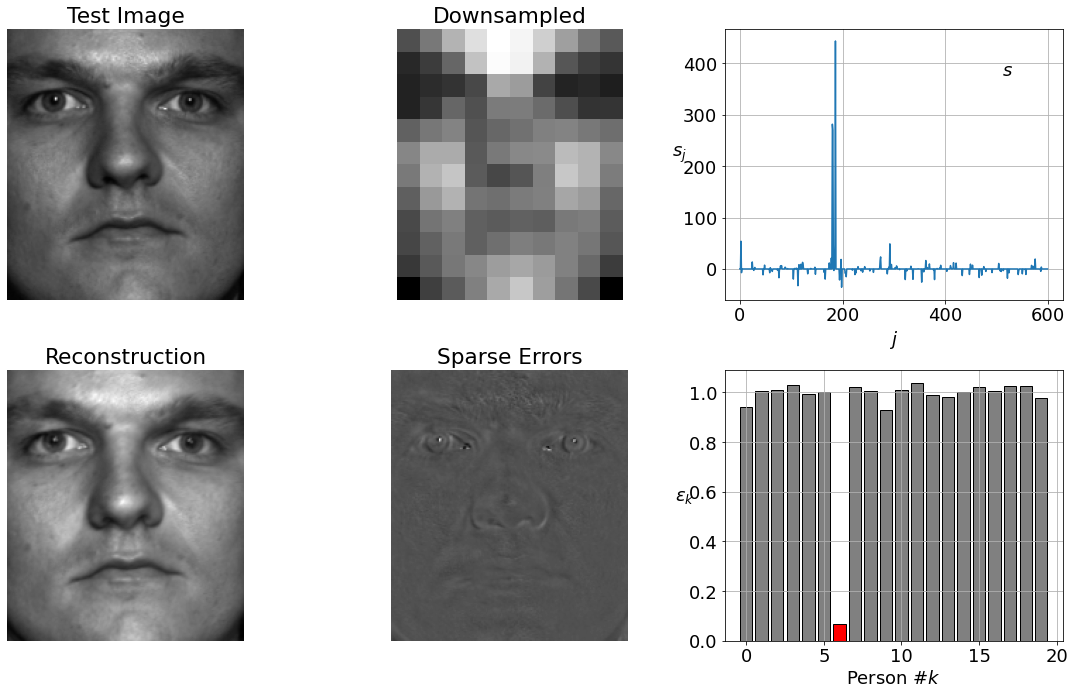

In [8]:
## L1 Search, Test clean
s1 = l1_fit(Θ, y1, eps=0.01)
plot_test(
    Train, ntrain, npeople,
    m=m, n=n, m_down=m_down, n_down=n_down,
    theta_norms=Θ_norm,
    x=x1, y=y1, s=s1
)

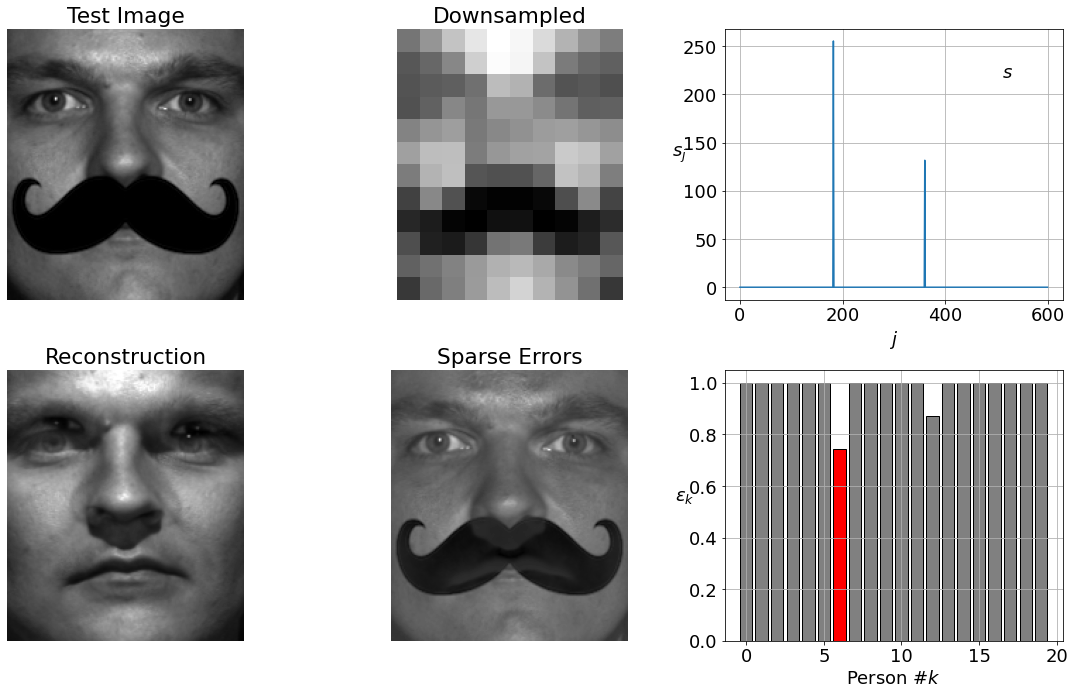

In [9]:
## L1 Search, Mustache
s2 = l1_fit(Θ, y2, eps=500)
plot_test(
    Train, ntrain, npeople,
    m=m, n=n, m_down=m_down, n_down=n_down,
    theta_norms=Θ_norm,
    x=x2, y=y2, s=s2
)

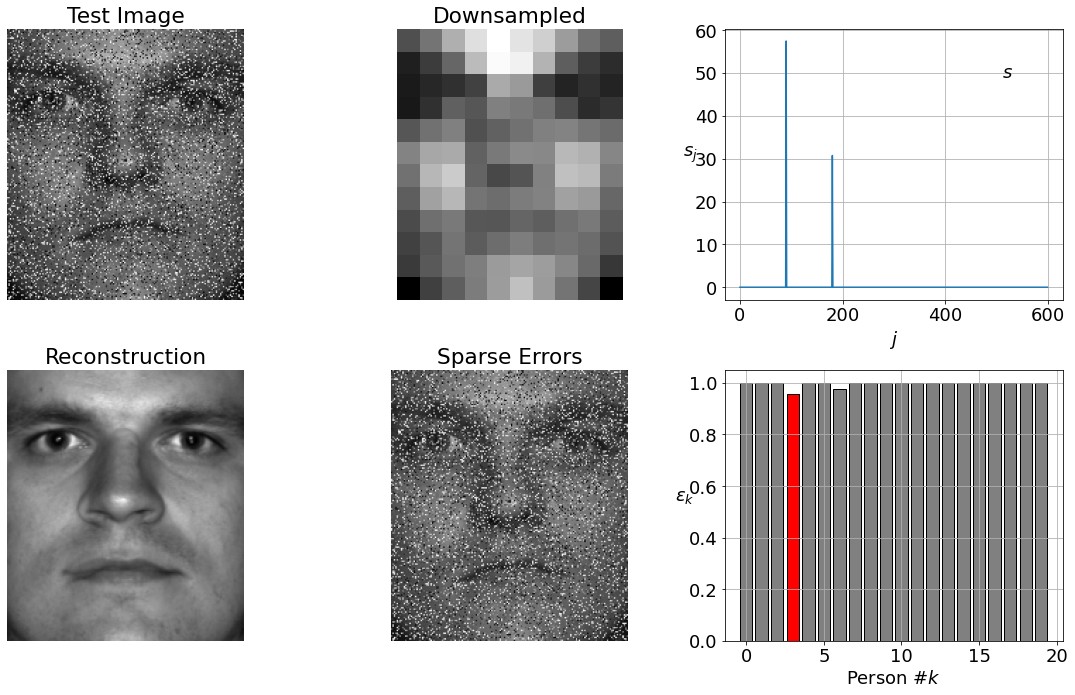

In [10]:
## L1 Search, Occlusion
s3 = l1_fit(Θ, y3, eps=1000)
plot_test(
    Train, ntrain, npeople,
    m=m, n=n, m_down=m_down, n_down=n_down,
    theta_norms=Θ_norm, x=x3, y=y3, s=s3
)

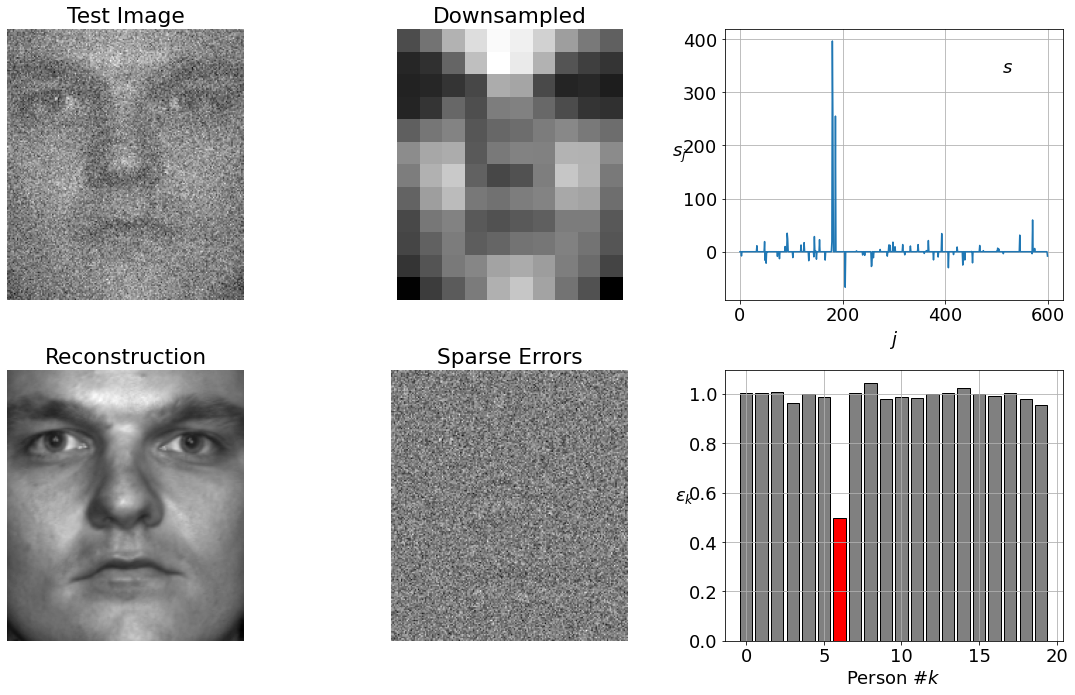

In [11]:
## L1 Search, Noise
s4 = l1_fit(Θ, y4, eps=10)
plot_test(
    Train, ntrain, npeople,
    m=m, n=n, m_down=m_down, n_down=n_down,
    theta_norms=Θ_norm,
    x=x4, y=y4, s=s4
)

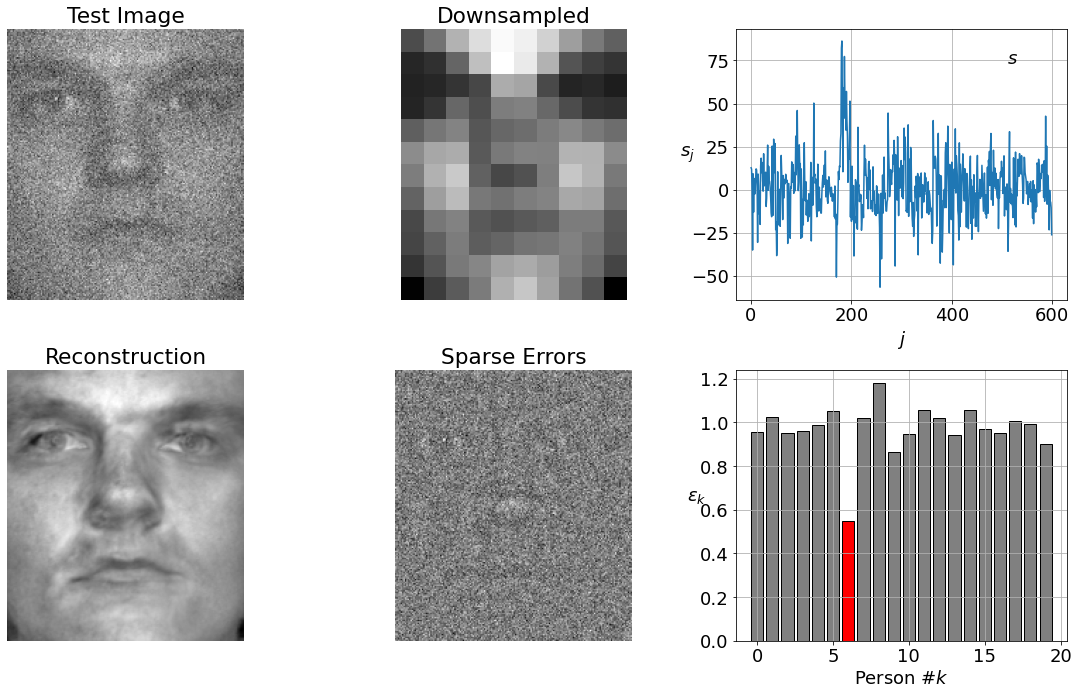

In [12]:
# L2 fit doesn't really work
s4_l2 = pinv(Θ) @ y4
plot_test(
    Train, ntrain, npeople,
    m=m, n=n, m_down=m_down, n_down=n_down,
    theta_norms=Θ_norm,
    x=x4, y=y4, s=s4_l2
)